In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder
)

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
data = pd.read_csv("./AB_NYC_2019.csv")

excluding_list = [
    'price', 'id', 'latitude', 'longitude', 
    'host_id', 'last_review', 'name', 'host_name'
    ] 

low_card_categorical = [
    'neighbourhood_group',
    'room_type'
    ] 

high_card_categorical = ['neighbourhood']

continuous = [
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month', 
    'calculated_host_listings_count',
    'availability_365'
] 

In [3]:
target_mean = (data["price"] > data["price"].mean()).astype(int)
target_median = (data["price"] > data["price"].median()).astype(int)
target_multiclass = pd.qcut(data["price"], q=5, labels=False)
target_regression = data["price"]

In [4]:
categorical_onehot = OneHotEncoder(handle_unknown='ignore')
categorical_ordinal = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
numeric_standardization = Pipeline(
    steps=[
        ('scaler', StandardScaler()),
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),

    ]
)
column_transform = ColumnTransformer(
    [
        ('low_card_categories', categorical_onehot, low_card_categorical),
        ('high_card_categories', categorical_ordinal, high_card_categorical),
        ('numeric', numeric_standardization, continuous)
    ],
    remainder='drop', # Dropping any remaining unprocessed columns
    verbose_feature_names_out=False,
    sparse_threshold=0.0
)

lm_column_transform = ColumnTransformer(
    [
        ('low_card_categories', categorical_onehot, low_card_categorical),
        ('numeric', numeric_standardization, continuous)
    ],
    remainder='drop', # Dropping any remaining unprocessed columns
    verbose_feature_names_out=False,
    sparse_threshold=0.0
) # High cardinality features left apart for linear models

### Multivariate Imputation

In [6]:
from sklearn.experimental import (
    enable_iterative_imputer
)

from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor

In [14]:
Xm = data[continuous].copy()
missing_perc = 0.05
np.random.seed(0)
mask = np.random.rand(*Xm.shape) < missing_perc
Xm[mask] = np.nan

simple_imputer = SimpleImputer()
Xm_si = simple_imputer.fit_transform(Xm)

rf = RandomForestRegressor(max_samples=0.5)
multivar_imputer = IterativeImputer(
    estimator=rf,
    max_iter=1,
    tol=0.01
)

Xm_mi = multivar_imputer.fit_transform(Xm)
mae = pd.DataFrame(
    {
        "simple": np.mean(np.abs(data[continuous] - Xm_si), axis=0),
        "multivariate": np.mean(np.abs(data[continuous] - Xm_mi), axis=0)
    },
    index= continuous
)

print(mae)

                                  simple  multivariate
minimum_nights                  0.347355      0.260010
number_of_reviews               1.327776      0.838272
reviews_per_month               0.057980      0.035983
calculated_host_listings_count  0.579423      0.366860
availability_365                6.025748      4.522035


c:\Users\tunahan.kilic\OneDrive - ERIKS\Desktop\Developer\ml-for-tabulardata\.venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


### Target Encoding

In [15]:
def bin_2_cat(feature, bins=100):
    min_value = feature.min()
    max_value = feature.max()
    bin_width = (max_value - min_value) / bins  
    bin_values = (feature - min_value) / bin_width
    return bin_values.astype(int)

In [16]:
data['coordinates'] = (
    bin_2_cat(data['latitude']) * 1000 + bin_2_cat(data['longitude'])
)

high_card_categorical += ['coordinates']

print(data[high_card_categorical].nunique())

neighbourhood     221
coordinates      2259
dtype: int64


In [8]:
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score

In [19]:
target_encoder = TargetEncoder(
    cols=high_card_categorical,
    smoothing=0.5,
)
accuracy = make_scorer(accuracy_score)
xgb = XGBClassifier(
    booster='gbtree',
    objective='reg:logistic',
    n_estimators=300,
    max_depth=4,
    min_child_weight=3,
)
kf = KFold(n_splits=5, shuffle=True, random_state=0)

column_transform = ColumnTransformer(
    [
        ('low_card_categories', categorical_onehot, low_card_categorical),
        ('high_card_categories', target_encoder, high_card_categorical),
        ('numeric', numeric_standardization, continuous)
    ],
    remainder='drop', # Dropping any remaining unprocessed columns
    verbose_feature_names_out=True,
    sparse_threshold=0.0
)

model_pipeline = Pipeline(
    steps=[
        ('column_transform', column_transform),
        ('model', xgb)
    ]
)

cv_scores = cross_validate(
    model_pipeline,
    data,
    target_median,
    cv=kf,
    scoring=accuracy,
    return_train_score=True,
    return_estimator=True
)

train_cv = np.mean(cv_scores['train_score'])
mean_cv = np.mean(cv_scores['test_score'])
std_cv = np.std(cv_scores['test_score'])    
fit_time = np.mean(cv_scores['fit_time'])
score_time = np.mean(cv_scores['score_time'])   
print(f"Train: {train_cv:.3f} |",
      f"Test: {mean_cv:0.3f} ({std_cv:0.3f}) |", 
      f"fit: {fit_time:0.2f}", f"secs pred: {score_time:0.2f} secs")

Train: 0.878 | Test: 0.840 (0.002) | fit: 0.46 secs pred: 0.03 secs


## Partial Dependence Plot (PDP)

In [6]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

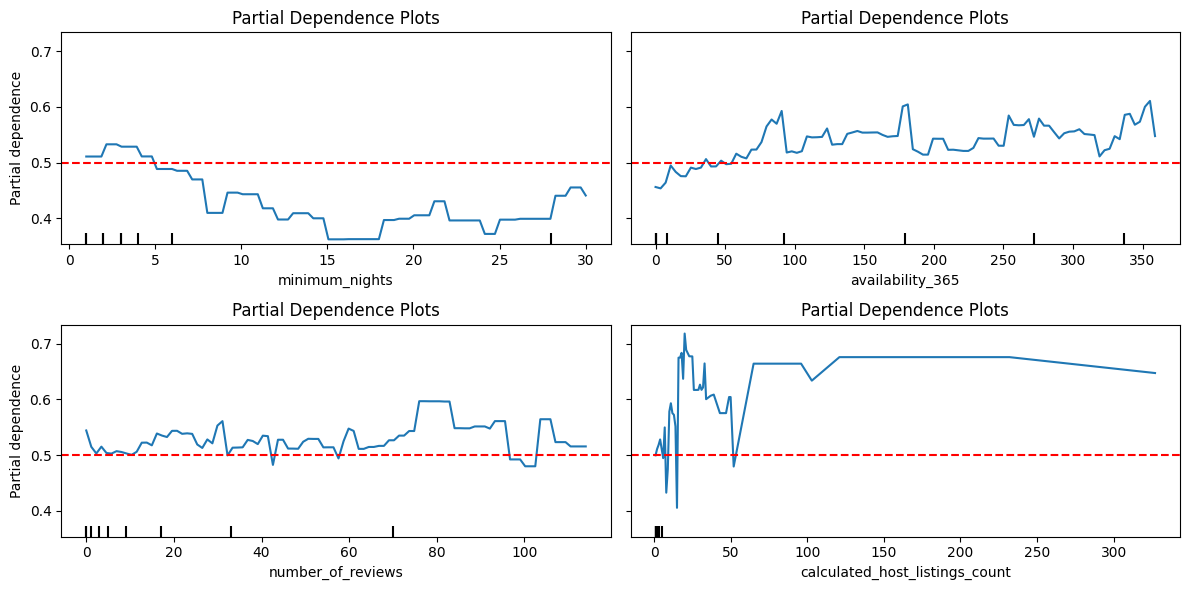

In [12]:
xgb = XGBClassifier(
    booster='gbtree',
    objective='reg:logistic',
    n_estimators=300,
    max_depth=4,
    min_child_weight=3,
)
model_pipeline = Pipeline(
    steps=[
        ('column_transform', column_transform),
        ('model', xgb)
    ]
)

model_pipeline.fit(data, target_median)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
PartialDependenceDisplay.from_estimator(
    model_pipeline,
    X=data,
    features=['minimum_nights', 'availability_365', 'number_of_reviews', 'calculated_host_listings_count'],
    ax=axes
)
for ax in axes.flatten():
    ax.set_title('Partial Dependence Plots')
    ax.axhline(0.5, color='red', linestyle='--')
plt.tight_layout()
plt.show()

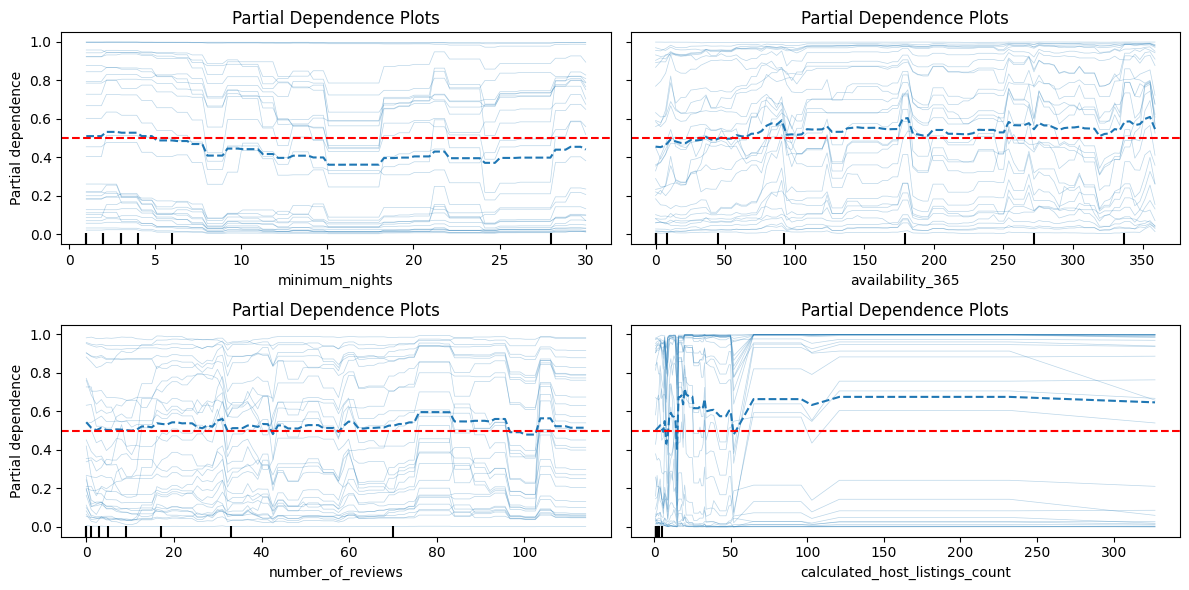

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
PartialDependenceDisplay.from_estimator(
    model_pipeline,
    X=data,
    kind='both',
    subsample=30,
    features=['minimum_nights', 'availability_365', 'number_of_reviews', 'calculated_host_listings_count'],
    ax=axes
)
for ax in axes.flatten():
    ax.set_title('Partial Dependence Plots')
    ax.axhline(0.5, color='red', linestyle='--')
    ax.legend().set_visible(False)
plt.tight_layout()
plt.show()

In [14]:
from sklearn.inspection import partial_dependence


In [19]:
pd_ice = partial_dependence(
    model_pipeline,
    X=data,
    features=['neighbourhood_group'],
    kind='both'
    )

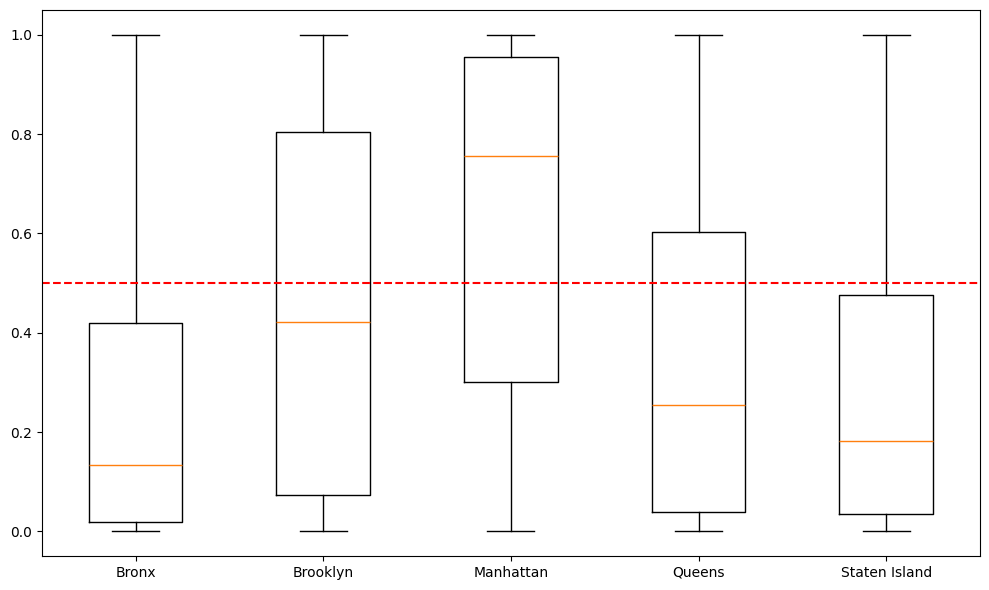

In [22]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
labels = np.ravel(pd_ice['grid_values'])
plt.boxplot(
    pd_ice["individual"].squeeze(),
    tick_labels=labels
)
ax.axhline(y=0.5, color='red', linestyle='--')
plt.tight_layout()
plt.show()

## Discovering Interactions with XGBFIR (XGB Feature Interactions Reshaped)

In [23]:
import xgbfir

In [25]:
xgbfir.saveXgbFI(
    model_pipeline['model'],
    feature_names=(
        model_pipeline['column_transform'].get_feature_names_out()
    ),
    OutputXlsxFile='fir.xlsx'
)

fir = pd.read_excel('fir.xlsx', sheet_name='Interaction Depth 1')
result = fir[['Interaction', "Gain"]].sort_values(by="Gain", ascending=False).head(10).round(2)

In [27]:
for index, row in result.iterrows():
 print(f"{row['Interaction']}")

neighbourhood_group_Manhattan|room_type_Entire home/apt
neighbourhood|neighbourhood
availability_365|neighbourhood_group_Manhattan
neighbourhood|neighbourhood_group_Manhattan
neighbourhood_group_Brooklyn|neighbourhood_group_Manhattan
availability_365|neighbourhood
calculated_host_listings_count|minimum_nights
neighbourhood|room_type_Entire home/apt
calculated_host_listings_count|neighbourhood
neighbourhood|neighbourhood_group_Brooklyn


In [26]:
result

,Interaction,Gain
0,neighbourhood_group_Manhattan|room_type_Entire...,90916.72
1,neighbourhood|neighbourhood,8671.01
2,availability_365|neighbourhood_group_Manhattan,6091.42
3,neighbourhood|neighbourhood_group_Manhattan,3466.00
4,neighbourhood_group_Brooklyn|neighbourhood_gro...,2342.59
5,availability_365|neighbourhood,2126.51
6,calculated_host_listings_count|minimum_nights,1691.87
7,neighbourhood|room_type_Entire home/apt,1254.99
8,calculated_host_listings_count|neighbourhood,1148.09
9,neighbourhood|neighbourhood_group_Brooklyn,1069.85


## Feature Selection

### Stability Selection

In [34]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier

In [32]:
lambda_grid = np.logspace(4, -1, 10)
sparse_coef = list()

In [35]:
categorical_onehot = OneHotEncoder(handle_unknown='ignore')

In [36]:
lm_column_transform = ColumnTransformer(
 [('low_card_categories', categorical_onehot, low_card_categorical),
 ],
 remainder='drop',
 verbose_feature_names_out=True,
 sparse_threshold=0.0)

In [37]:
for modeling_c in lambda_grid:
    estimator = LogisticRegression(
        solver='liblinear',
        penalty='l1',
        C=modeling_c,
    )
    model = BaggingClassifier(
        estimator,
        n_estimators=100,
        bootstrap=True
    )
    model_pipeline = Pipeline(
        steps=[
            ('processing', lm_column_transform),
            ('standardize', StandardScaler()),
            ('model', model)
        ]
    )
    model_pipeline.fit(data, target_median)
    sparse_coef += [estimator.coef_.ravel() for estimator in model_pipeline['model'].estimators_]

epsilon=1e-2
threshold=0.5

non_zero = (np.abs(sparse_coef) > epsilon).mean(axis=0)
feature_names = model_pipeline['processing'].get_feature_names_out()
print(non_zero)
print(feature_names[non_zero > threshold])

[1.    0.792 1.    0.999 1.    0.999 0.852 1.   ]
['low_card_categories__neighbourhood_group_Bronx'
 'low_card_categories__neighbourhood_group_Brooklyn'
 'low_card_categories__neighbourhood_group_Manhattan'
 'low_card_categories__neighbourhood_group_Queens'
 'low_card_categories__neighbourhood_group_Staten Island'
 'low_card_categories__room_type_Entire home/apt'
 'low_card_categories__room_type_Private room'
 'low_card_categories__room_type_Shared room']


### Boruta Selection

In [39]:
from xgboost import XGBClassifier
from boruta import BorutaPy

In [40]:
xgb = XGBClassifier(
    booster='gbtree',
    objective='reg:logistic',
    n_estimators=300,
    max_depth=4,
    min_child_weight=3,
)

X = column_transform.fit_transform(data, target_median)
boruta_selector = BorutaPy(
    estimator=xgb,
    n_estimators='auto',
    verbose=2,
)
boruta_selector.fit(X, target_median)
selected_features = boruta_selector.support_
selected_data = column_transform.get_feature_names_out()[selected_features]
print(selected_data)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	13
Tentative: 	0
Rejected: 	1


BorutaPy finished running.

Iteration: 	10 / 100
Confirmed: 	13
Tentative: 	0
Rejected: 	1
['neighbourhood_group_Bronx' 'neighbourhood_group_Brooklyn'
 'neighbourhood_group_Manhattan' 'neighbourhood_group_Queens'
 'room_type_Entire home/apt' 'room_type_Private room'
 'room_type_Shared room' 'neighbourhood' 'minimum_nights'
 'number_of_reviews' 'reviews_per_month' 'calculated_host_listings_count'
 'availability_365']


In [41]:
from lightgbm import LGBMClassifier

In [42]:
lgbm = LGBMClassifier(
    boosting_type='gbdt',
    n_estimators=300,
    max_depth=4,
    min_child_samples=3
)

boruta_selector = BorutaPy(
    estimator=lgbm,
    n_estimators='auto',
    verbose=2,
)
boruta_selector.fit(X, target_median)
selected_features = boruta_selector.support_
selected_data = column_transform.get_feature_names_out()[selected_features]
print(selected_data)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	8
Tentative: 	0
Rejected: 	6


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	8
Tentative: 	0
Rejected: 	6
['neighbourhood_group_Manhattan' 'room_type_Entire home/apt'
 'neighbourhood' 'minimum_nights' 'number_of_reviews' 'reviews_per_month'
 'calculated_host_listings_count' 'availability_365']


### Lofo Feature Importance

In [ ]:
from sklearn.model_selection import StratifiedKFold
from lofo import LOFOImportance, plot_importance, Dataset

100%|██████████| 8/8 [00:12<00:00,  1.51s/it]


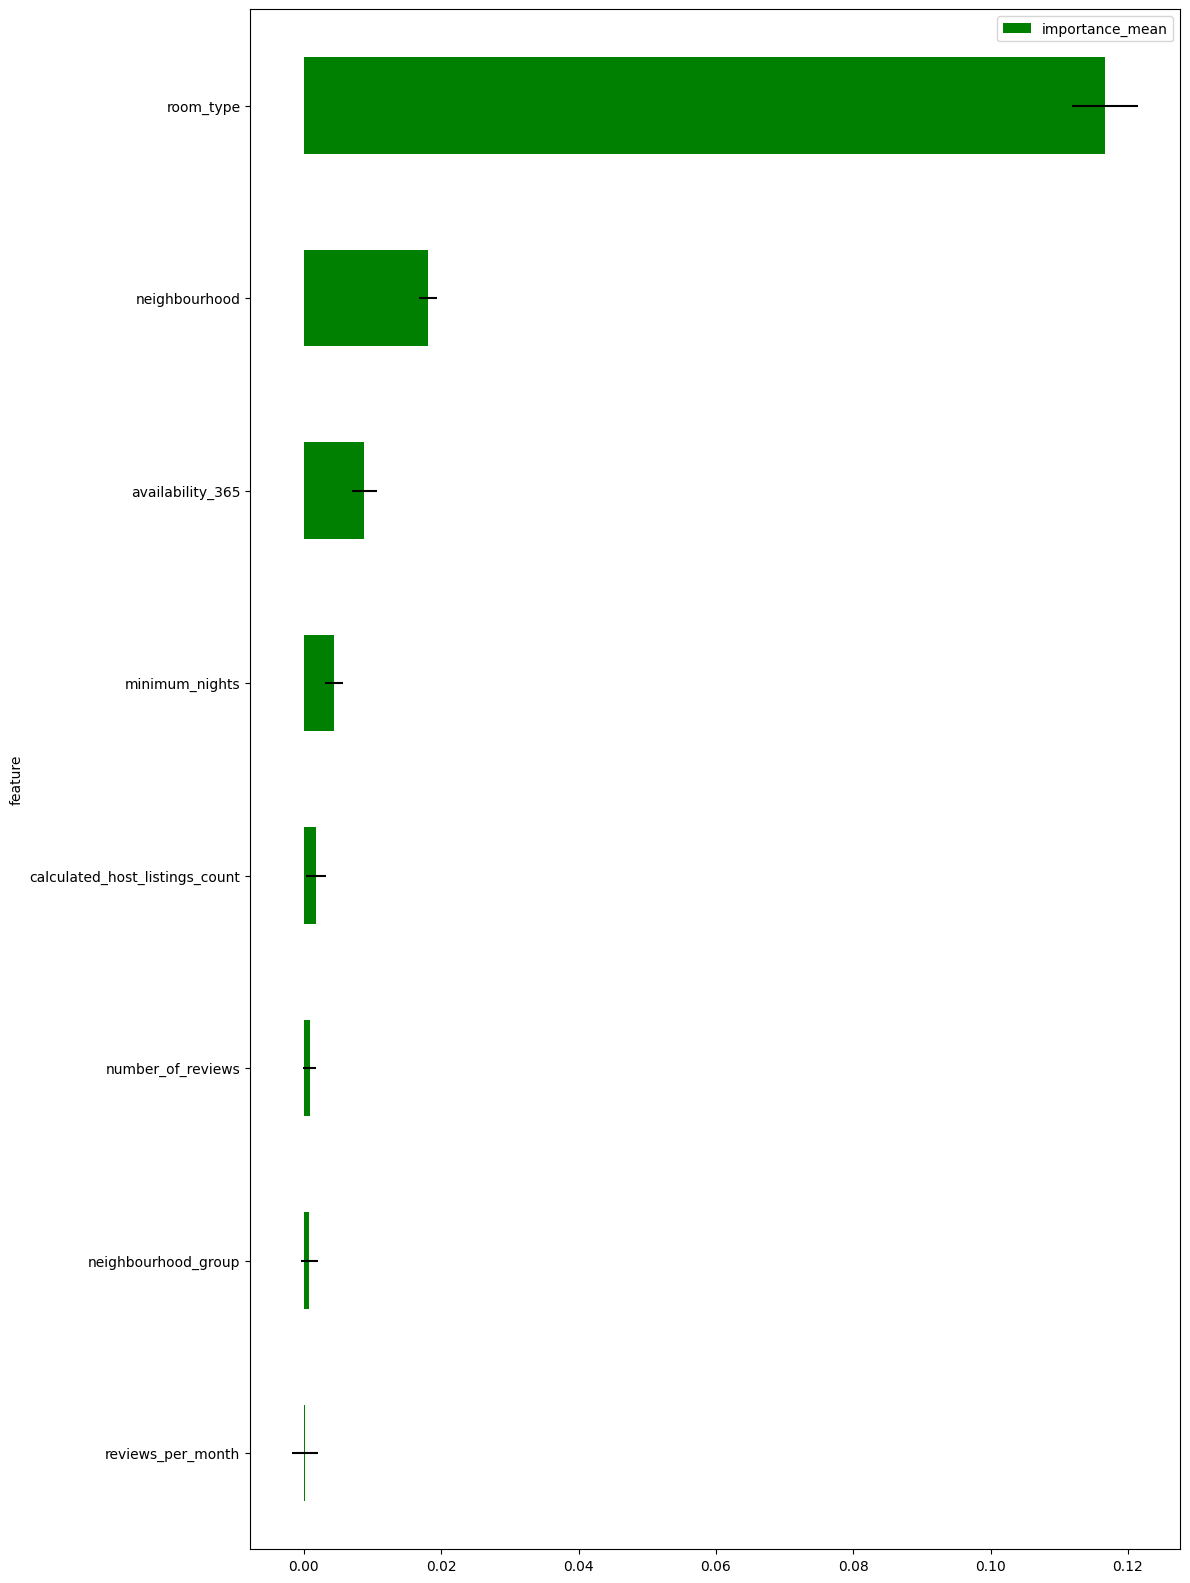

In [74]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
COLS = low_card_categorical + high_card_categorical + continuous
sample_df = pd.concat([data[COLS], target_median], axis='columns')
lofo_data = Dataset(df=sample_df, target='price', features=COLS)
lofo_imp = LOFOImportance(lofo_data, cv=cv, scoring='neg_root_mean_squared_error')
importance_df = lofo_imp.get_importance()
plot_importance(importance_df, figsize=(12, 20))